# Part 1: Generate Data

The next few cells generate simulation data. This simulates a one-dimensional road where the car we are tracking can only move forwards or backwards.

For this simulated data, the tracked vehicle starts 5 meters ahead of us traveling at 100 km/h. The vehicle is accelerating at -10 m/s^2. In other words, the vehicle is slowing down. 

Once the vehicle stops at 0 km/h, the car stays idle for 5 seconds. Then the vehicle continues accelerating towards us until the vehicle is traveling at -10 km/h. The vehicle travels at -10 km/h for 5 seconds.

We simulate a single lidar sensor that tracks a car's motion. This simulated lidar sensor takes a measurment once every 50 milliseconds.

In [12]:
%matplotlib inline

import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib
import datagenerator
import matrix as m
import numpy
# numpy.random.bit_generator = numpy.random._bit_generator

matplotlib.rcParams.update({'font.size': 16})

# data_groundtruth() has the following inputs:
# Generates Data
# Input variables are:
# initial position meters
# initial velocity km/h
# final velocity (should be a negative number) km/h
# acceleration (should be a negative number) m/s^2
# how long the vehicle should idle 
# how long the vehicle should drive in reverse at constant velocity
# time between lidar measurements in milliseconds

time_groundtruth, distance_groundtruth, velocity_groundtruth, acceleration_groundtruth = datagenerator.generate_data(5, 100, -10, -10,
                                                                                              5000, 5000, 50)
data_groundtruth = pd.DataFrame(
    {'time': time_groundtruth,
     'distance': distance_groundtruth,
     'velocity': velocity_groundtruth,
     'acceleration': acceleration_groundtruth
    })

### Visualizing the Tracked Object Distance

The next cell visualizes the simulating data. The first visualization shows the object distance over time. We can see that the car is moving forward although decelerating. Then the car stops for 5 seconds and then drives backwards for 5 seconds.

[Text(0, 0.5, 'distance (meters)'), Text(0.5, 0, 'time (milliseconds)')]

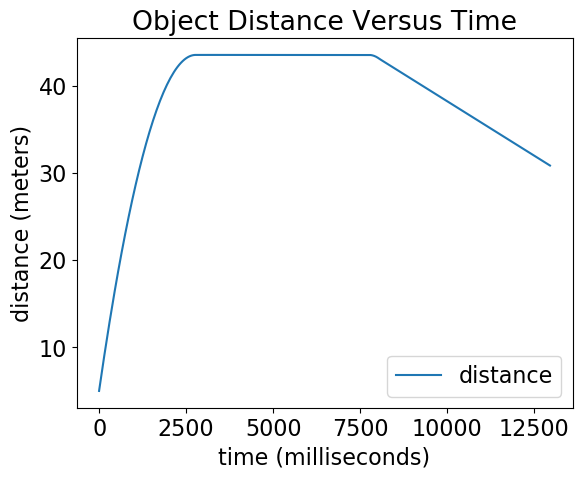

In [13]:
ax1 = data_groundtruth.plot(kind='line', x='time', y='distance', title='Object Distance Versus Time')
ax1.set(xlabel='time (milliseconds)', ylabel='distance (meters)')

### Visualizing Velocity Over Time

The next cell outputs a visualization of the velocity over time. The tracked car starts at 100 km/h and decelerates to 0 km/h. Then the car idles and eventually starts to decelerate again until reaching -10 km/h. 

[Text(0, 0.5, 'velocity (km/h)'), Text(0.5, 0, 'time (milliseconds)')]

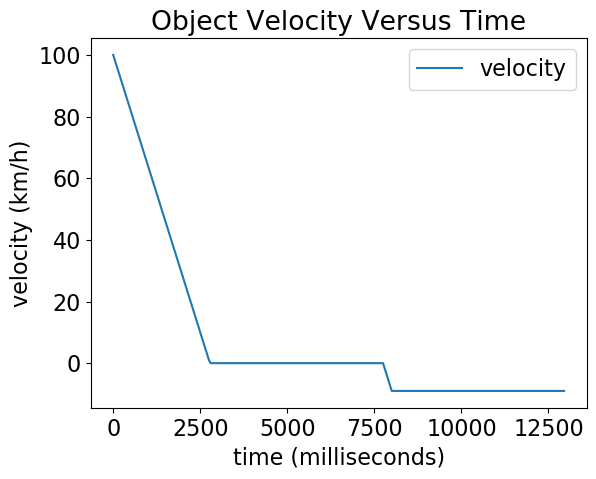

In [14]:
ax2 = data_groundtruth.plot(kind='line', x='time', y='velocity', title='Object Velocity Versus Time')
ax2.set(xlabel='time (milliseconds)', ylabel='velocity (km/h)')

### Visualizing Acceleration Over Time

This cell visualizes the tracked cars acceleration. The vehicle declerates at 10 m/s^2. Then the vehicle stops for 5 seconds and briefly accelerates again. 

[Text(0, 0.5, 'acceleration (m/s^2)'), Text(0.5, 0, 'time (milliseconds)')]

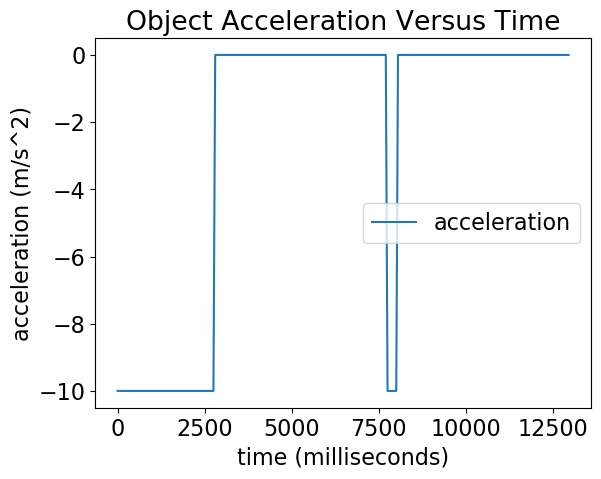

In [15]:
data_groundtruth['acceleration'] = data_groundtruth['acceleration'] * 1000 / math.pow(60 * 60, 2)
ax3 = data_groundtruth.plot(kind='line', x='time', y='acceleration', title='Object Acceleration Versus Time')
ax3.set(xlabel='time (milliseconds)', ylabel='acceleration (m/s^2)')

### Simulating Lidar Data

The following code cell creates simulated lidar data. Lidar data is noisy, so the simulator takes ground truth measurements every 0.05 seconds and then adds random noise.

In [16]:
# make lidar measurements
lidar_standard_deviation = 0.15
lidar_measurements = datagenerator.generate_lidar(distance_groundtruth, lidar_standard_deviation)
lidar_time = time_groundtruth

### Visualizing Lidar Meausrements

The following cell visualizes the lidar measurements versus the ground truth. The ground truth is shown in red, and we can see that the lidar measurements are a bit noisy.

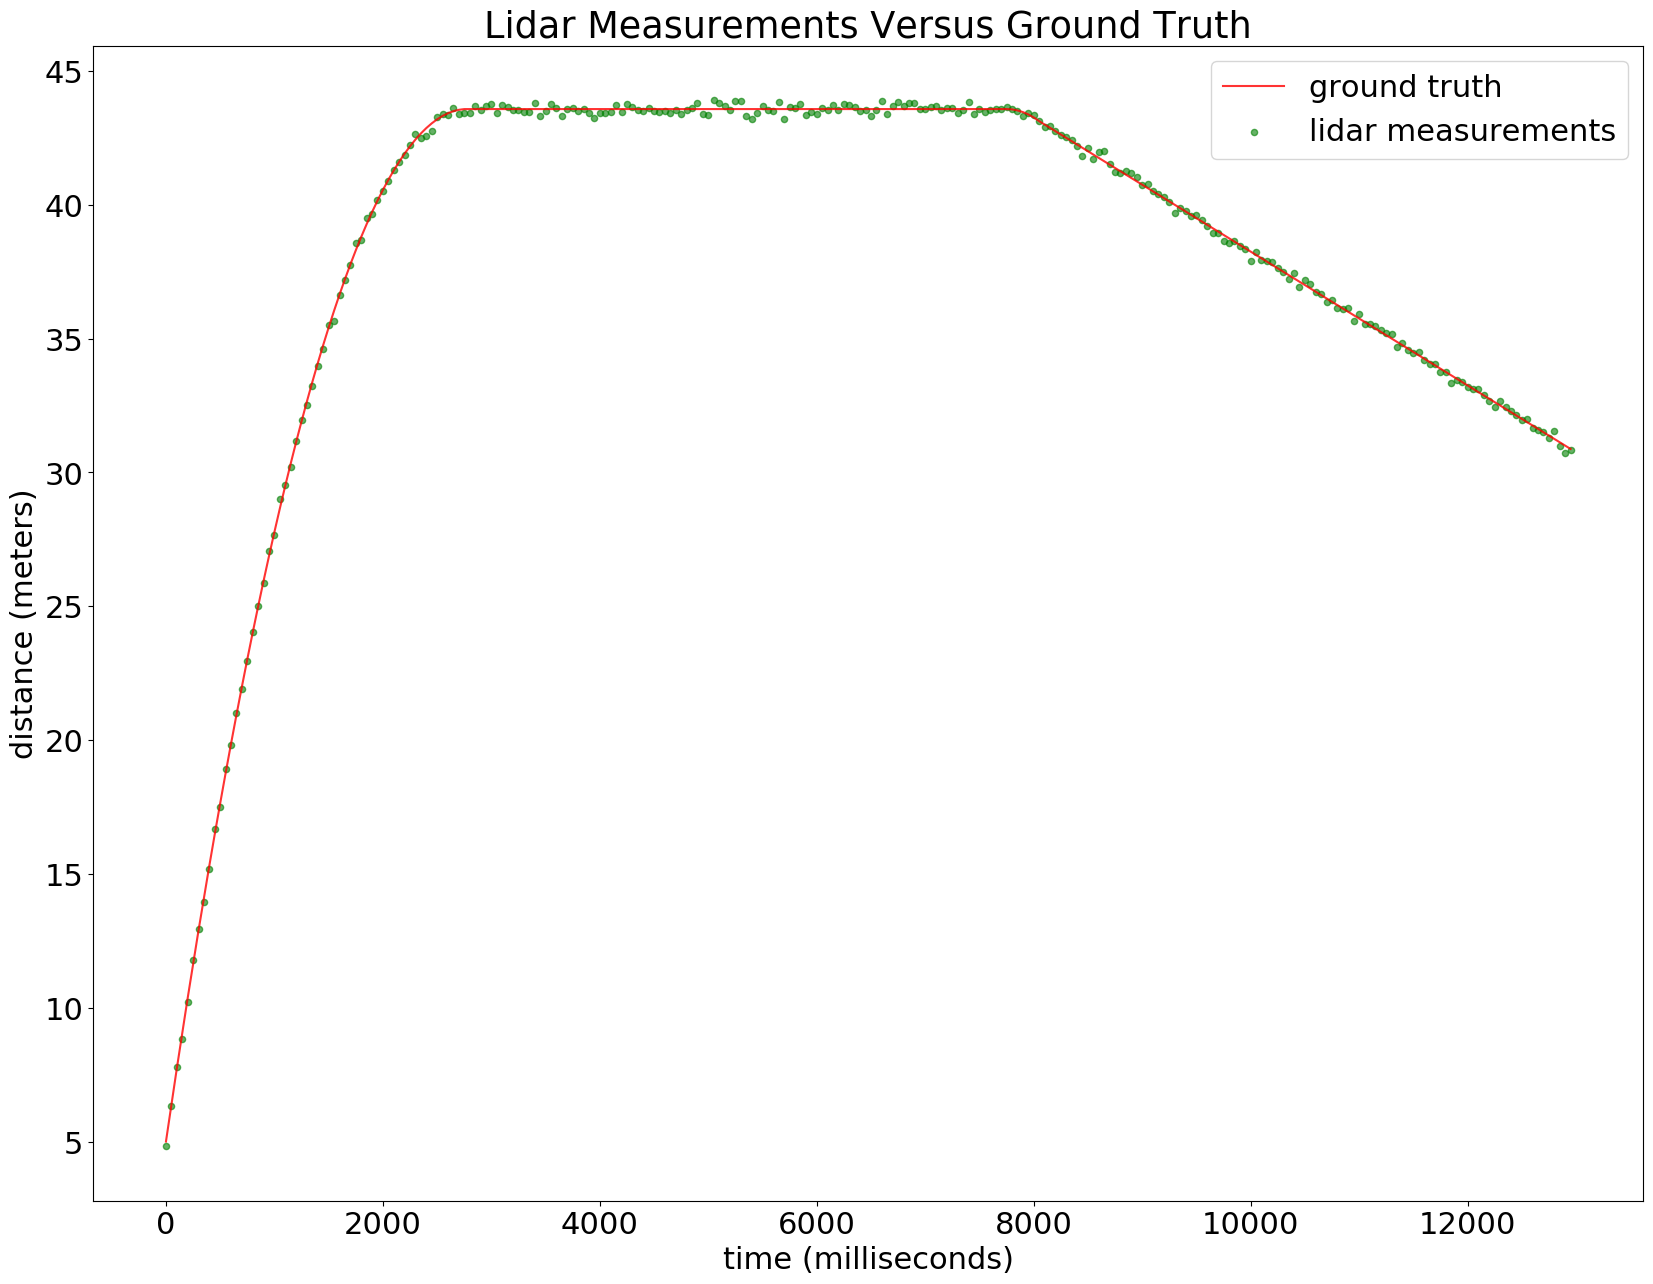

In [17]:
data_lidar = pd.DataFrame(
    {'time': time_groundtruth,
     'distance': distance_groundtruth,
     'lidar': lidar_measurements
    })

matplotlib.rcParams.update({'font.size': 22})

ax4 = data_lidar.plot(kind='line', x='time', y ='distance', label='ground truth', figsize=(20, 15), alpha=0.8,
               title = 'Lidar Measurements Versus Ground Truth', color='red')
ax5 = data_lidar.plot(kind='scatter', x ='time', y ='lidar', label='lidar measurements', ax=ax4, alpha=0.6, color='g')
ax5.set(xlabel='time (milliseconds)', ylabel='distance (meters)')
plt.show()

# Part 2: Kalman Filter

This first cell initializes variables and defines a few functions. The following cell runs the Kalman filter using the lidar data.



In [19]:
# Kalman Filter Initialization

initial_distance = 0
initial_velocity = 0

x_initial = m.Matrix([[initial_distance], [initial_velocity * 1e-3 / (60 * 60)]])
P_initial = m.Matrix([[5, 0],[0, 5]])

acceleration_variance = 50
lidar_variance = math.pow(lidar_standard_deviation, 2)

H = m.Matrix([[1, 0]])
R = m.Matrix([[lidar_variance]])
I = m.identity(2)

def F_matrix(delta_t):
    return m.Matrix([[1, delta_t], [0, 1]])

def Q_matrix(delta_t, variance):
    t4 = math.pow(delta_t, 4)
    t3 = math.pow(delta_t, 3)
    t2 = math.pow(delta_t, 2)
    
    return variance * m.Matrix([[(1/4)*t4, (1/2)*t3], [(1/2)*t3, t2]])

### Running the Implementation

The next code cell runs the Kalman filter. In this demonstration, the prediction step starts with the second lidar measurement. When the first lidar signal arrives, there is no previous lidar measurement with which to calculate velocity. In other words, the Kalman filter predicts where the vehicle is going to be, but it can't make a prediction until time has passed between the first and second lidar reading. 

The Kalman filter has two steps: a prediction step and an update step. In the prediction step, the filter uses a motion model to figure out where the object has traveled in between sensor measurements. The update step uses the sensor measurement to adjust the belief about where the object is.

In [20]:
# Kalman Filter Implementation

x = x_initial
P = P_initial

x_result = []
time_result = []
v_result = []


for i in range(len(lidar_measurements) - 1):
        
    # calculate time that has passed between lidar measurements
    delta_t = (lidar_time[i + 1] - lidar_time[i]) / 1000.0

    # Prediction Step - estimates how far the object traveled during the time interval
    F = F_matrix(delta_t)
    Q = Q_matrix(delta_t, acceleration_variance)
    
    x_prime = F * x
    P_prime = F * P * F.T() + Q
    
    # Measurement Update Step - updates belief based on lidar measurement
    y = m.Matrix([[lidar_measurements[i + 1]]]) - H * x_prime
    S = H * P_prime * H.T() + R
    K = P_prime * H.T() * S.inverse()
    x = x_prime + K * y
    P = (I - K * H) * P_prime

    # Store distance and velocity belief and current time
    x_result.append(x[0][0])
    v_result.append(3600.0/1000 * x[1][0])
    time_result.append(lidar_time[i+1])
    
result = pd.DataFrame(
    {'time': time_result,
     'distance': x_result,
     'velocity': v_result
    })

### Visualizing the Displacement

The following code cell outputs a visualization of the Kalman filter. The chart contains ground turth, the lidar measurements, and the Kalman filter belief. The Kalman filter tends to smooth out the information obtained from the lidar measurement.

Using multiple sensors like radar and lidar at the same time will give even better results. This utilization of more than one type of sensor at once is known as sensor fusion, which I hope to learn in the future.

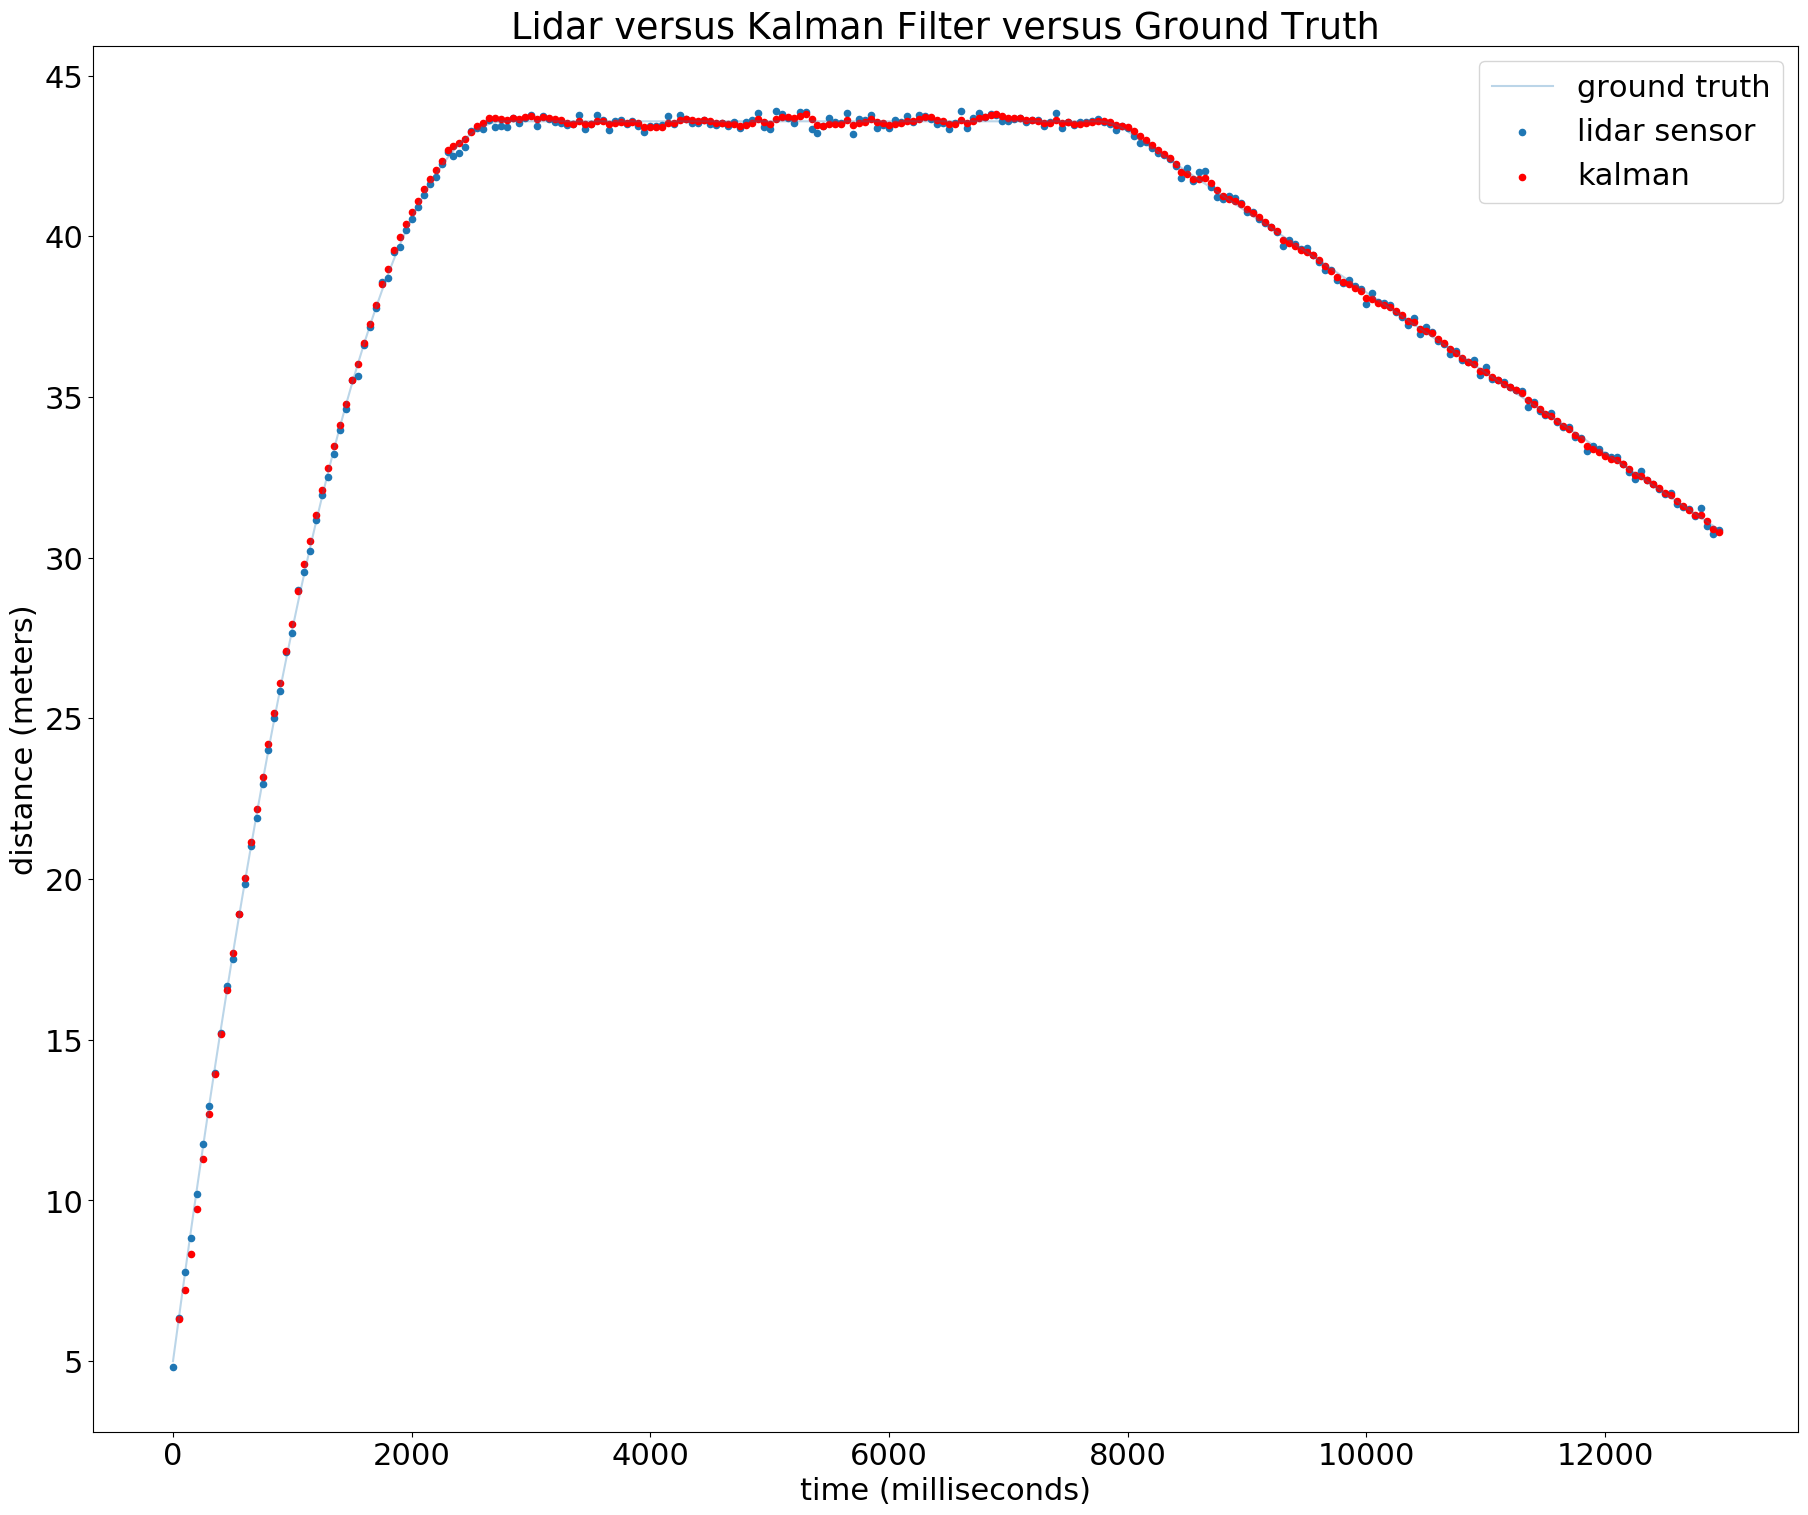

In [21]:
ax6 = data_lidar.plot(kind='line', x='time', y ='distance', label='ground truth', figsize=(22, 18), alpha=.3, title='Lidar versus Kalman Filter versus Ground Truth')
ax7 = data_lidar.plot(kind='scatter', x ='time', y ='lidar', label='lidar sensor', ax=ax6)
ax8 = result.plot(kind='scatter', x = 'time', y = 'distance', label='kalman', ax=ax7, color='r')
ax8.set(xlabel='time (milliseconds)', ylabel='distance (meters)')
plt.show()

### Visualizing the Velocity

One of the most interesting benefits of Kalman filters is that they can give us insights into variables that we
cannot directly measured. Although lidar does not directly give velocity information, the Kalman filter can infer velocity from the lidar measurements.

This visualization shows the Kalman filter velocity estimation versus the ground truth. The motion model used in this Kalman filter is relatively simple; it assumes velocity is constant and that acceleration a random noise. We can see that this motion model might be too simplistic because the Kalman filter has trouble predicting velocity as the object decelerates.

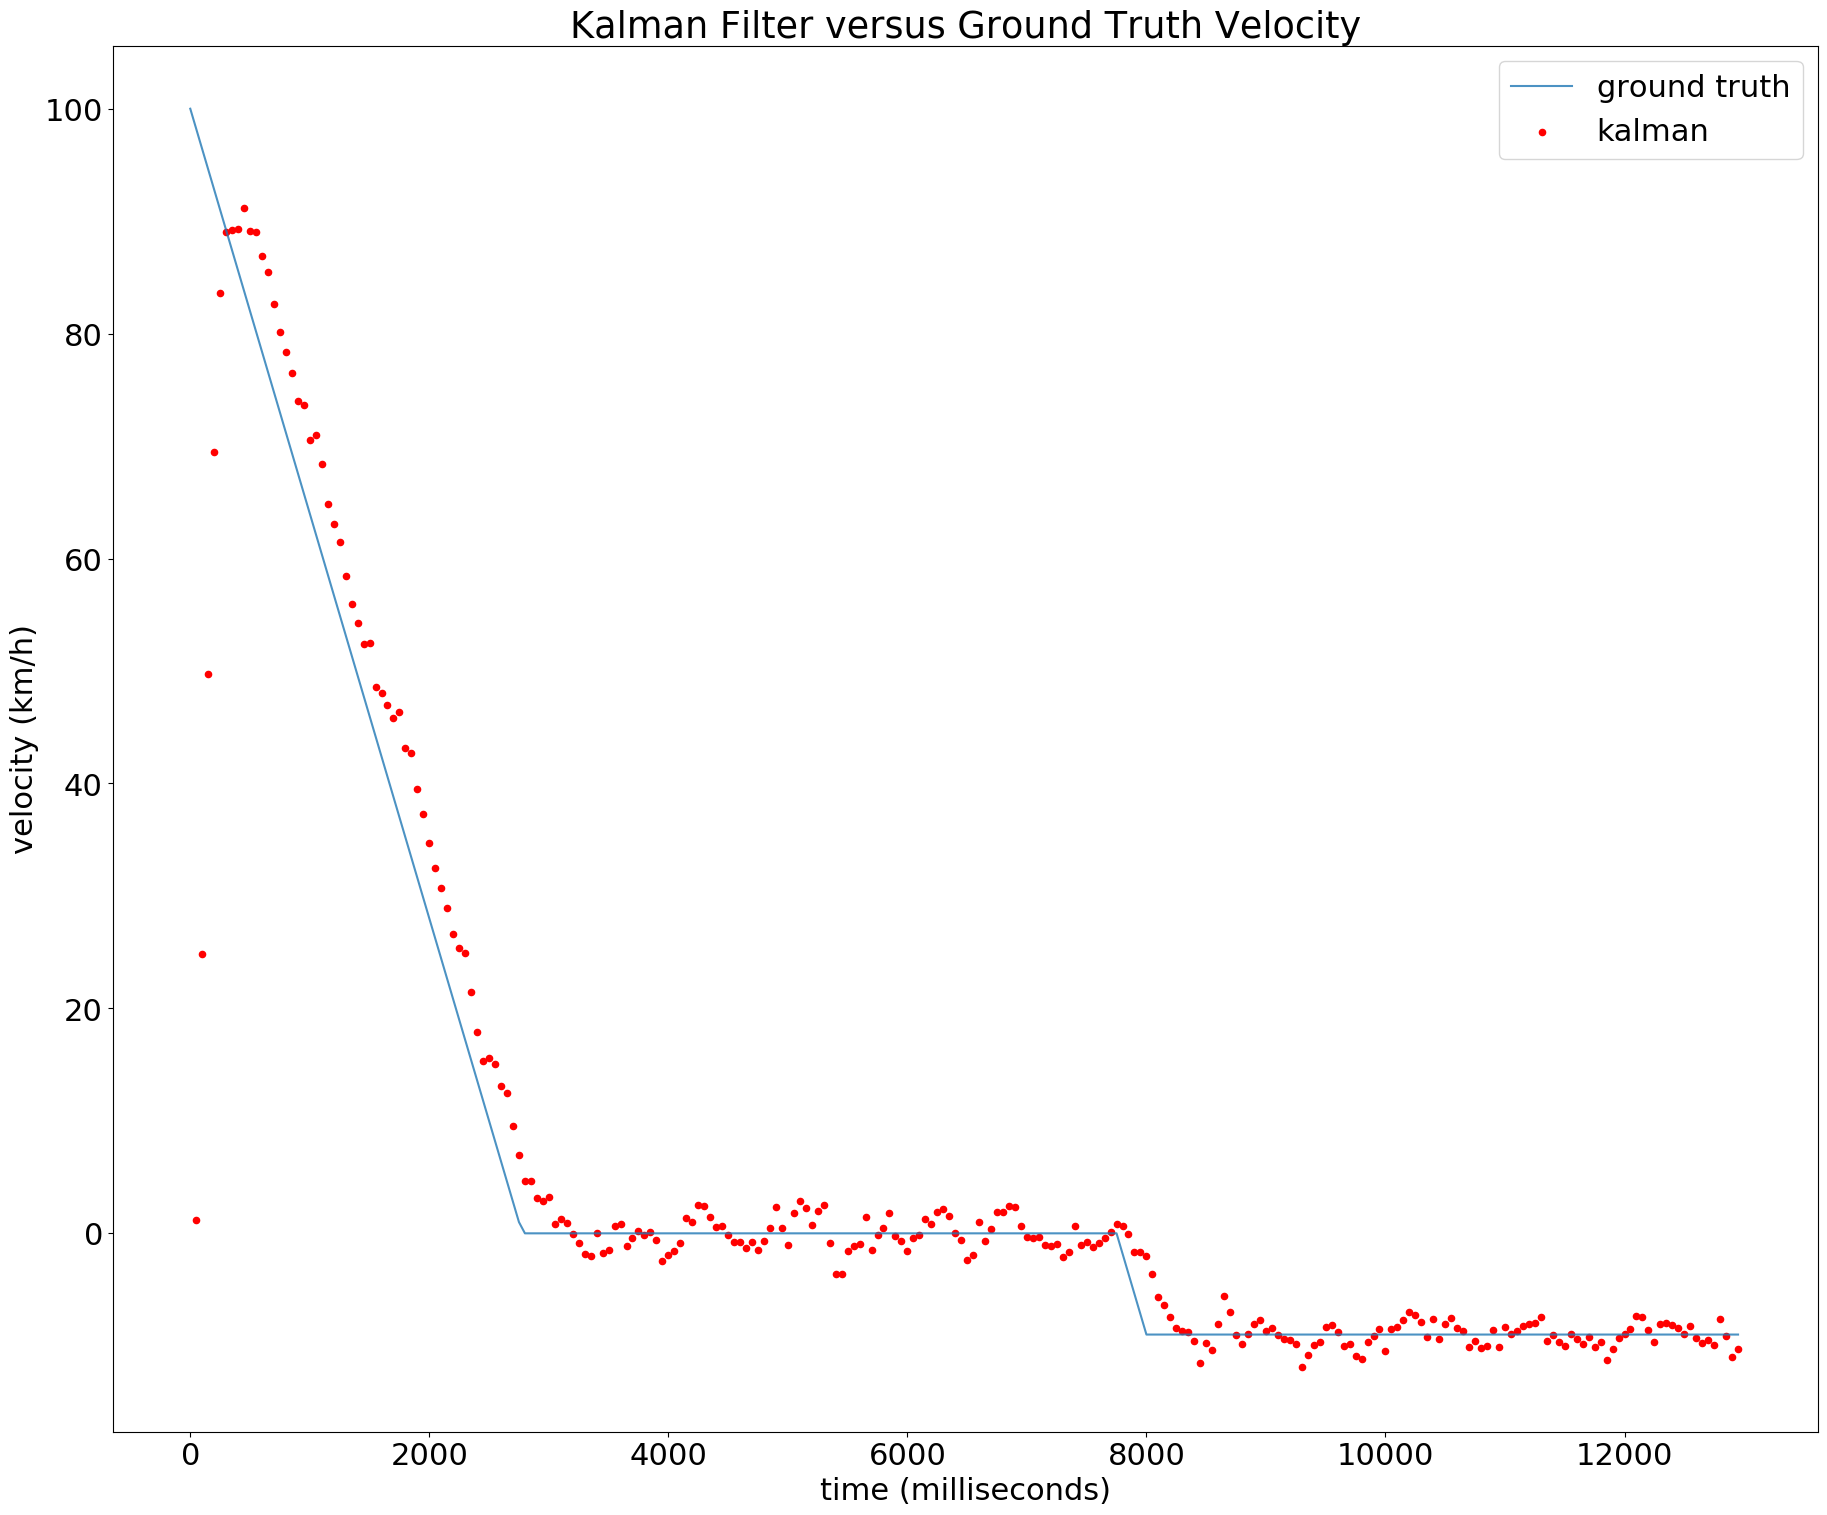

In [22]:
ax1 = data_groundtruth.plot(kind='line', x='time', y ='velocity', label='ground truth', figsize=(22, 18), alpha=.8, title='Kalman Filter versus Ground Truth Velocity')
ax2 = result.plot(kind='scatter', x = 'time', y = 'velocity', label='kalman', ax=ax1, color='r')
ax2.set(xlabel='time (milliseconds)', ylabel='velocity (km/h)')
plt.show()